In [2]:
!pip install dmba
import dmba
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import math
from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
pd.set_option('display.width', 180)

**Question 1: University Rankings.**

The dataset on American College and University Rankings (available from www.dataminingbook.com) contains information on 1302 American colleges and universities offering an undergraduate program. For each university, there are 17
measurements, including continuous measurements (such as tuition and graduation rate) and categorical measurements (such as location by state and whether it is a private or public school).

Note that many records are missing some measurements. Our first goal is to estimate these missing values from “similar” records. This will be done by clustering the complete records and then finding the closest cluster for each of the partial records. The missing values will be imputed from the information in that cluster.

In [ ]:
df = dmba.load_data('Universities.csv')
df.head(5)

,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
1,University of Alaska at Fairbanks,AK,1,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,5226.0,1800.0,1790.0,155.0,650.0,2304.0,67.0,10.0,NaN
2,University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
3,University of Alaska at Anchorage,AK,1,2065.0,1598.0,1162.0,NaN,NaN,6209.0,10537.0,1742.0,5226.0,2600.0,2520.0,114.0,580.0,1260.0,48.0,13.7,NaN
4,Alabama Agri. & Mech. Univ.,AL,1,2817.0,1920.0,984.0,NaN,NaN,3958.0,305.0,1700.0,3400.0,1108.0,1442.0,155.0,500.0,850.0,53.0,14.3,40.0


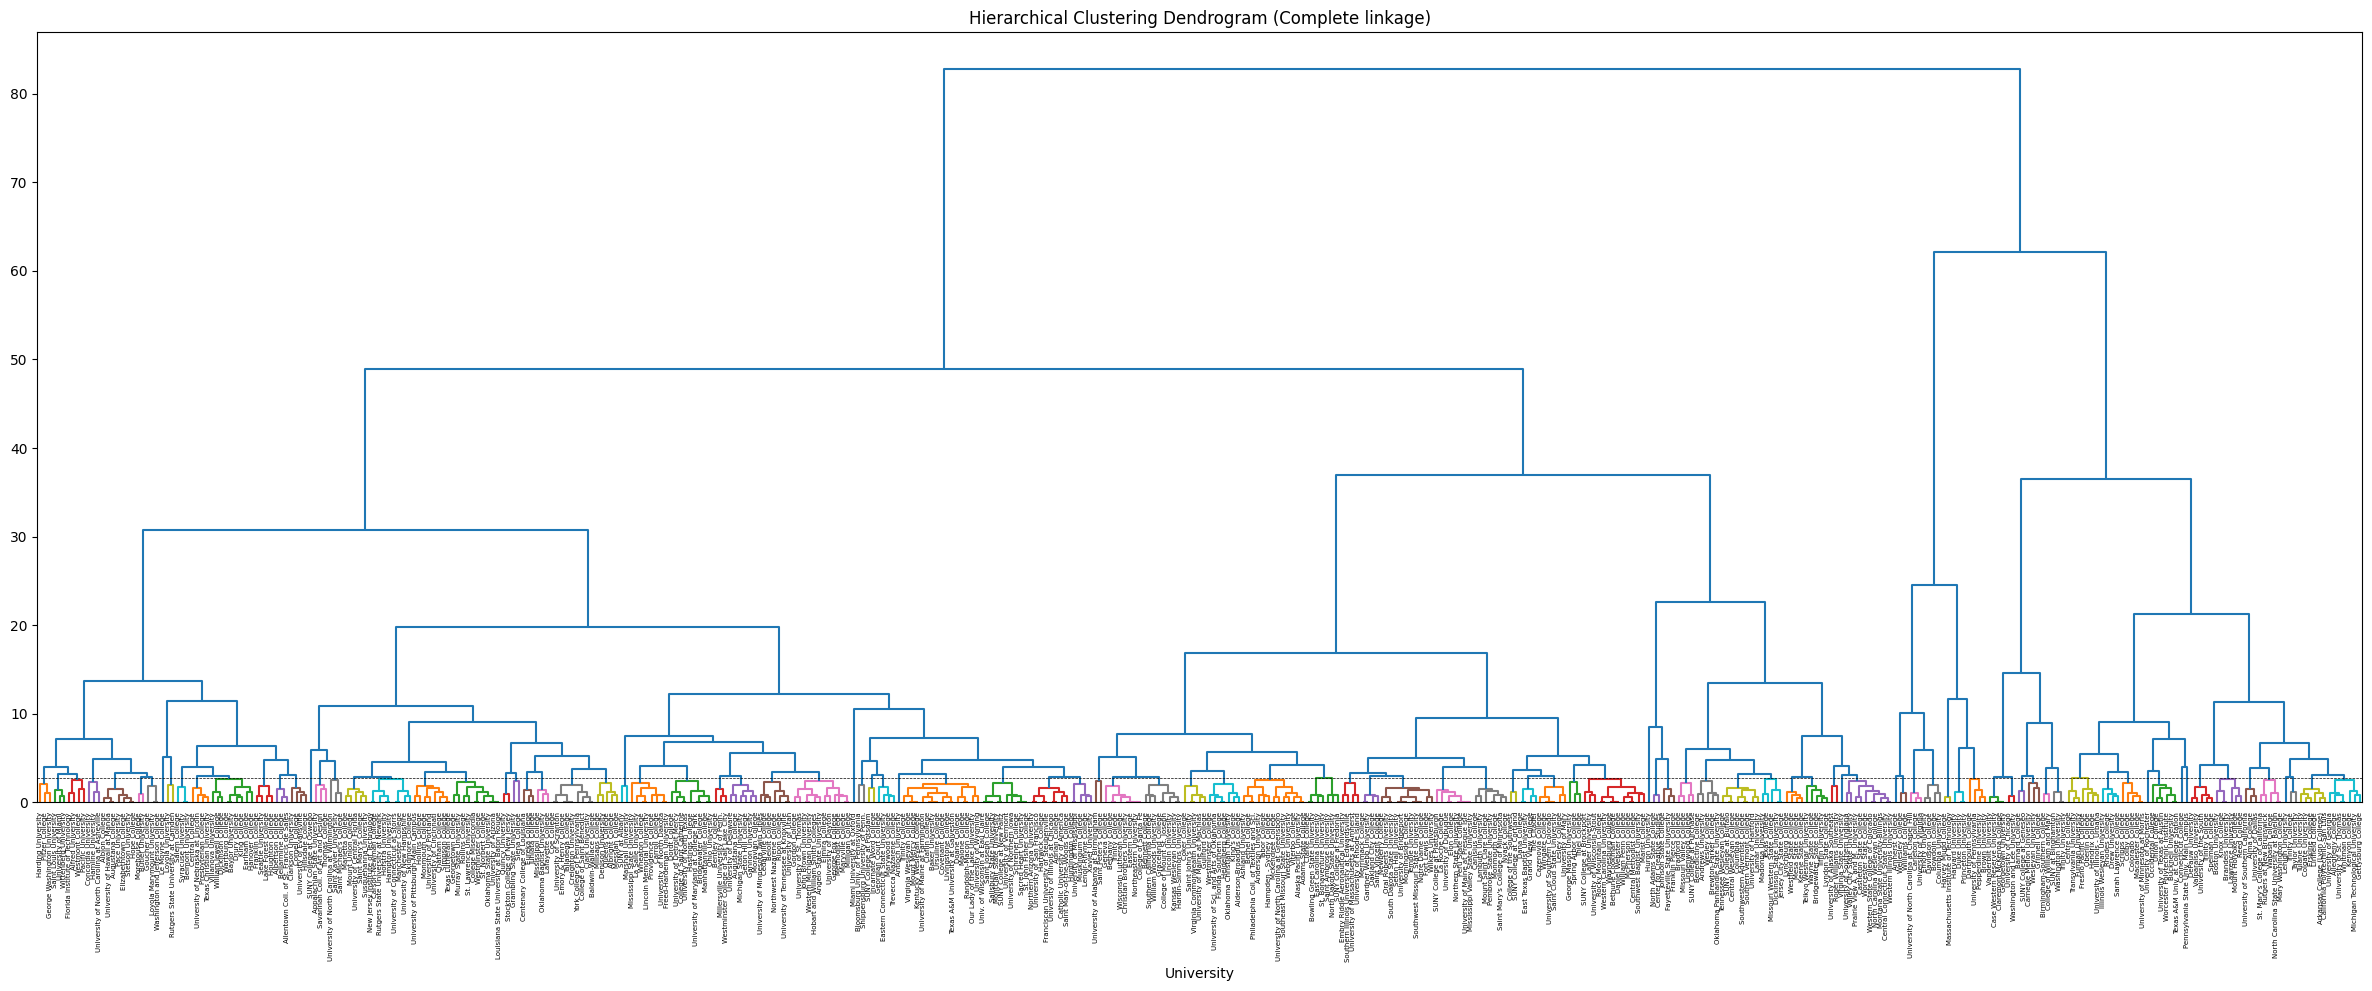

In [ ]:
df = dmba.load_data('Universities.csv')

# A. Data Cleaning: Remove all records with missing measurements from the dataset
df = df.dropna(axis=0, how='any')
df.set_index('College Name', inplace=True)

# B. Hierarchical Clustering: For all continuous measurements, apply hierarchical clustering
# using complete linkage and Euclidean distance. Be sure to normalize the data before clustering.
# Based on the dendrogram, how many clusters seem appropriate for this dataset?
new_df = df
new_df = new_df.drop(['State'], axis=1)
new_df_norm = (new_df - new_df.mean())/new_df.std()
new_d_norm = pairwise.pairwise_distances(new_df_norm[['% new stud. from top 10%', '% new stud. from top 25%']],
                                     metric='euclidean')
z = linkage(new_d_norm, method='complete')
fig = plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('University')
dendrogram(z, labels=new_df_norm.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()
# Given the dendrogram, it seems that the appropriate number of clusters would be 3

In [ ]:
# C. Cluster Characterization: Compare the summary statistics (e.g., mean or median) for each
# cluster. Describe the characteristics of each cluster in context (e.g., "Universities with high
# tuition, low acceptance rates..."). Hint: You can use the pandas groupby(clusterlabel)
# method along with aggregation methods like mean or median to summarize each cluster.
new_df["Cluster"] = fcluster(linkage(new_d_norm, 'complete'), 3, criterion='maxclust')
new_df = new_df.drop(['Public (1)/ Private (2)',"# appli. rec'd",'# appl. accepted',
                      '# new stud. enrolled', '# FT undergrad', '# PT undergrad'], axis=1)
print("Cluster 1:")
clust_one = new_df.groupby(["Cluster"]).get_group(1).mean().to_frame()
print(clust_one)

print('\nCluster 2:')
clust_two = new_df.groupby(["Cluster"]).get_group(2).mean().to_frame()
print(clust_two)

print('\nCluster 3:')
clust_three = new_df.groupby(["Cluster"]).get_group(3).mean().to_frame()
print(clust_three)
# Cluster 1 has the least % students from top 10% and 25%, lowest costs, lowest graduation rate
# Cluster 2 has the most % students from top 10% and 25%, highest costs, lowest student:faculty ratio
# Cluster 3 has the average "mean" statistics under most listed categories

Cluster 1:
                                    0
% new stud. from top 10%    20.502660
% new stud. from top 25%    48.031915
in-state tuition          8258.603723
out-of-state tuition      9488.805851
room                      2108.664894
board                     2036.869681
add. fees                  372.986702
estim. book costs          540.896277
estim. personal $         1357.087766
% fac. w/PHD                69.739362
stud./fac. ratio            14.569149
Graduation rate             61.734043
Cluster                      1.000000

Cluster 2:
                                     0
% new stud. from top 10%     83.210526
% new stud. from top 25%     96.947368
in-state tuition          16987.947368
out-of-state tuition      17830.789474
room                       2974.210526
board                      2795.473684
add. fees                   495.368421
estim. book costs           631.578947
estim. personal $          1100.263158
% fac. w/PHD                 94.105263
stud./fac. ratio

In [ ]:
# D. Categorical Analysis: Use the categorical variables (State and Private/Public) that were not
# part of the clustering to describe each cluster. Is there any noticeable relationship between the
# clusters and these categorical variables?
cat_df = new_df[['Cluster']]
cat_df['State'] = df['State']
cat_df['Public (1)/ Private (2)'] = df['Public (1)/ Private (2)']

print("Cluster 1:")
print(cat_df.groupby(["Cluster"]).get_group(1).mode())
print('\nCluster 2:')
print(cat_df.groupby(["Cluster"]).get_group(2).mode())
print('\nCluster 3:')
print(cat_df.groupby(["Cluster"]).get_group(3).mode())
# By obtaining the mode of each cluster for the state and public/private, it can be determined that:
# Cluster 1 is most frequently located in PA, and private
# Cluster 2 is most frequently located in MA, and private
# Cluster 3 is most frequently located in CA and NY, and private

# E. External Information: What other external information could help explain the characteristics
# of some or all of the clusters?
# Other information that would be helpful may include region of the country and demographic.
# The primary area of educational focus (STEM, Medical, Art, etc.) would also be helpful.

Cluster 1:
   Cluster State  Public (1)/ Private (2)
0        1    PA                        2

Cluster 2:
   Cluster State  Public (1)/ Private (2)
0        2    MA                        2

Cluster 3:
   Cluster State  Public (1)/ Private (2)
0      3.0    CA                      2.0
1      NaN    NY                      NaN


<ipython-input-39-2e582c1aa0b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['State'] = df['State']
<ipython-input-39-2e582c1aa0b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Public (1)/ Private (2)'] = df['Public (1)/ Private (2)']


In [ ]:
# F. Missing Data Imputation: Consider Harvard University, which has missing data. Compute
# the Euclidean distance between Harvard and each of the clusters you identified earlier, using
# only the available measurements. Which cluster is Harvard closest to? Impute the missing values
# for Harvard by taking the average of that cluster's corresponding measurements.
from sklearn.metrics.pairwise import euclidean_distances

df = dmba.load_data('Universities.csv')
df.set_index('College Name', inplace=True)
harvard = df.loc[df.index == 'Harvard University']
harvard = harvard.drop(['State','Public (1)/ Private (2)',"# appli. rec'd",'# appl. accepted',
                      '# new stud. enrolled', '# FT undergrad', '# PT undergrad'], axis=1)
harvard['Cluster'] = 0
clust_one = clust_one.transpose()
distance = euclidean_distances(harvard, clust_one)
print("Cluster One Dist: ", distance)

clust_two = clust_two.transpose()
distance = euclidean_distances(harvard, clust_two)
print("Cluster Two Dist: ", distance)

clust_three = clust_three.transpose()
distance = euclidean_distances(harvard, clust_three)
print("Cluster Three Dist: ", distance)
# Harvard is not missing any data measurements, but it would fit best in cluster 3
# The euclidean distance is most minimal for cluster two

Cluster One Dist:  [[13760.87568878]]
Cluster Two Dist:  [[2068.80821953]]
Cluster Three Dist:  [[7036.99167832]]


**Question 2: Pharmaceutical Industry.**

An equities analyst is studying the pharmaceutical industry and would like your help in exploring and understanding the financial data collected by her firm. Her main objective is to understand the structure of the pharmaceutical industry using some basic financial measures. Financial data gathered on 21 firms in the pharmaceutical industry are available in the file Pharmaceuticals.csv. Use cluster analysis to explore and analyze the given dataset as follows:

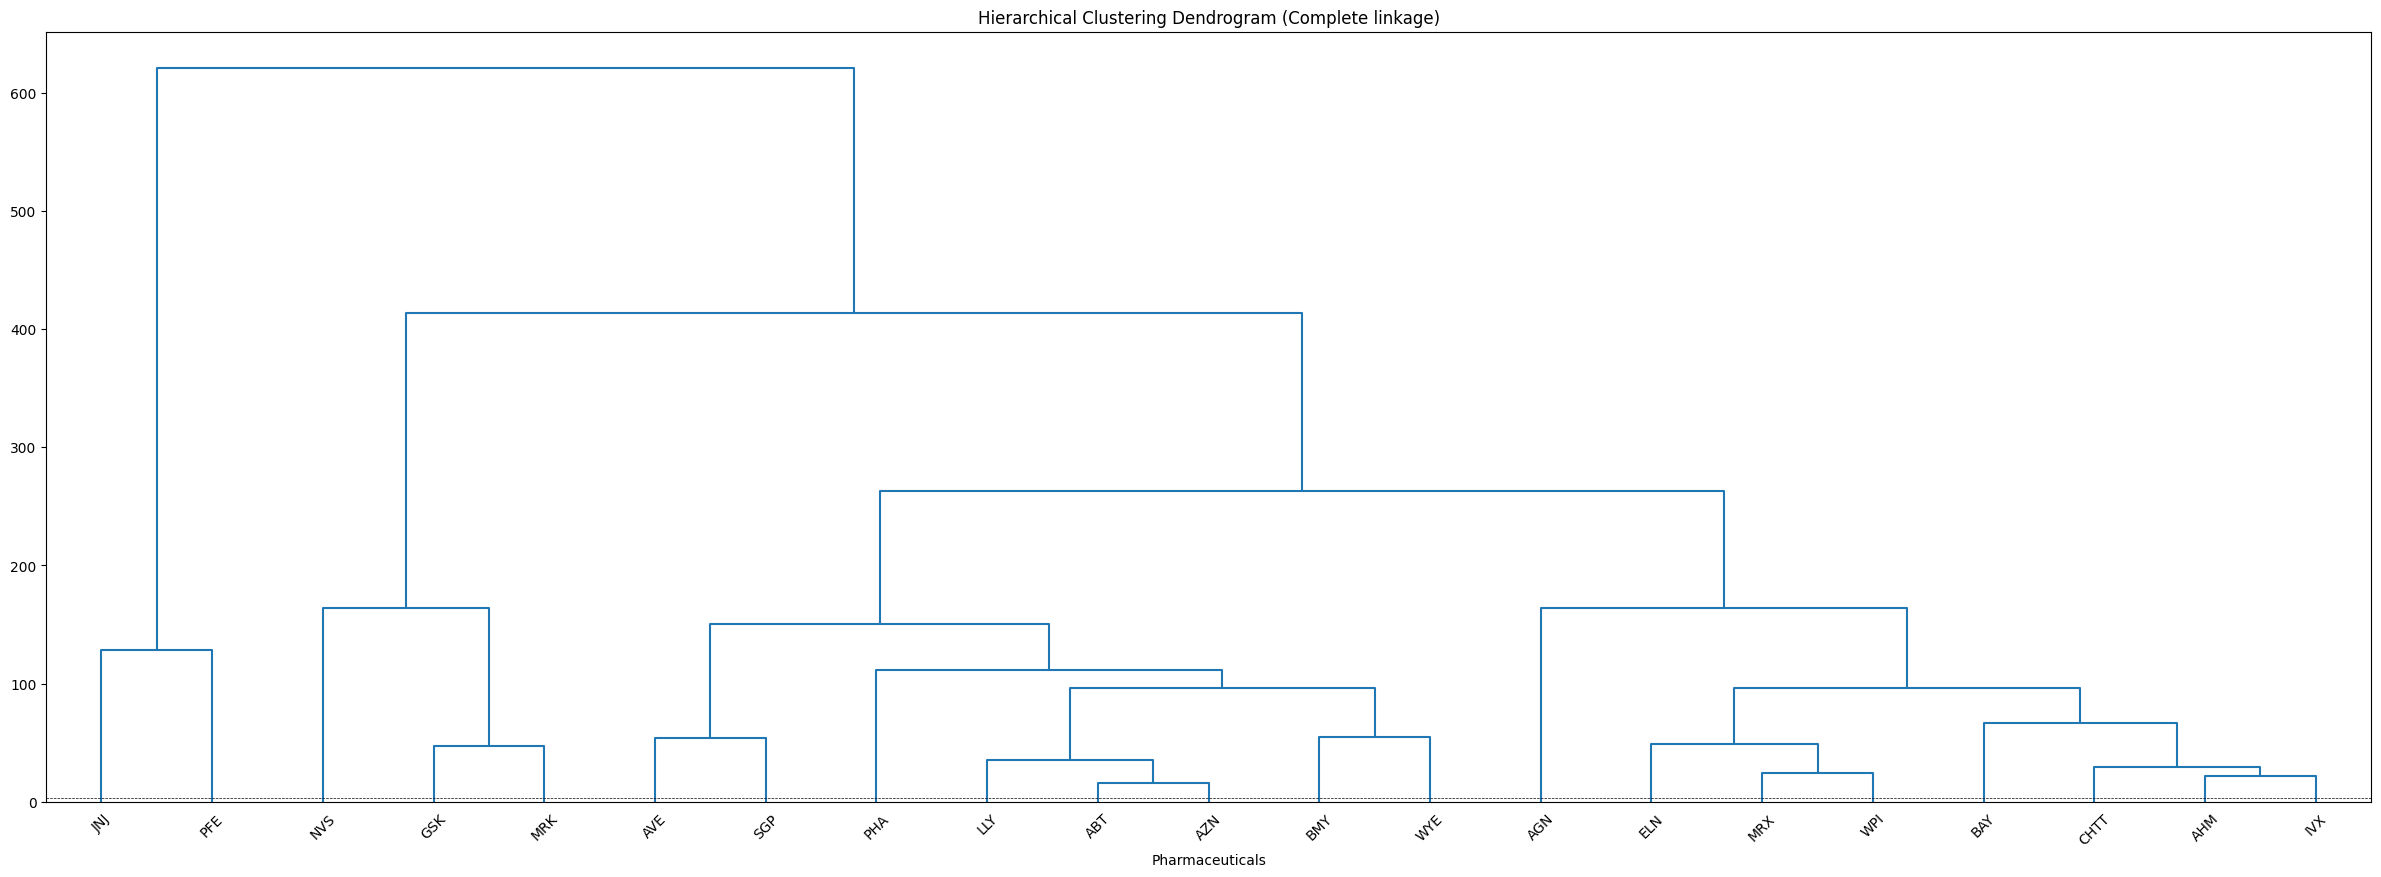

1 :  GSK, JNJ, MRK, PFE
2 :  ABT, AZN, AVE, BMY, LLY, NVS, SGP, WYE
3 :  AHM, BAY, CHTT, ELN, IVX, MRX, WPI
4 :  AGN, PHA

CATEGORICAL ANALYSIS:

Cluster 1:
  Median_Recommendation Location Exchange  Cluster
0          Moderate Buy       US     NYSE        1

Cluster 2:
  Median_Recommendation     Location Exchange  Cluster
0                  Hold  SWITZERLAND     NYSE      2.0
1                   NaN           UK      NaN      NaN
2                   NaN           US      NaN      NaN

Cluster 3:
  Median_Recommendation Location Exchange  Cluster
0                  Hold       US     NYSE        3

Cluster 4:
  Median_Recommendation Location Exchange  Cluster
0          Moderate Buy       US     NYSE        4

NUMERIC ANALYSIS:

Cluster 1:
   Market_Cap   Beta  PE_Ratio   ROE    ROA  Asset_Turnover  Leverage  Rev_Growth  Net_Profit_Margin  Cluster
0       186.7  0.555      26.0  37.1  17.75            0.85      0.13      17.455              21.55      1.0

Cluster 2:
   Market_Cap     

In [ ]:
df = dmba.load_data('Pharmaceuticals.csv')

# A. Use only the numerical variables (1–9) to cluster the 21 firms. Justify the various
# choices made in conducting the cluster analysis, such as weights for different
# variables, the specific clustering algorithm(s) used, the number of clusters
# formed, and so on.
df.set_index('Symbol', inplace=True)
df_dist = pairwise.pairwise_distances(df[['Market_Cap','Beta','PE_Ratio',
  'ROE','ROA','Asset_Turnover','Leverage','Rev_Growth','Net_Profit_Margin']], metric='euclidean')
z = linkage(df_dist, method='complete')
fig = plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Pharmaceuticals')
dendrogram(z, labels=df.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

memb = fcluster(linkage(df[['Market_Cap','Beta','PE_Ratio','ROE','ROA','Asset_Turnover',
  'Leverage','Rev_Growth','Net_Profit_Margin']], 'complete'), 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
# Four clusters chosen, complete euclidean distance-based dendrogram used to determine cluster amount
# No weights were assigned to particular variables

################################
#
# SIDE NOTE: B AND C ARE WRITTEN INCORRECTLY
# CATEGORICAL VARIABLES WERE NOT USED IN CLUSTER FORMATION
# NUMERICAL VARIABLES *WERE* USED IN CLUSTER FORMATION
#
################################

# B. Interpret the clusters with respect to the categorical variables used in forming the
# clusters.
df["Cluster"] = fcluster(linkage(df_dist, 'complete'), 4, criterion='maxclust')
cat_df = df
cat_df = cat_df.drop(['Name','Market_Cap','Beta','PE_Ratio',
  'ROE','ROA','Asset_Turnover','Leverage','Rev_Growth','Net_Profit_Margin'],axis=1)

print("\nCATEGORICAL ANALYSIS:\n")

print("Cluster 1:")
cat_clust_one = cat_df.groupby(["Cluster"]).get_group(1).mode()
print(cat_clust_one)

print('\nCluster 2:')
cat_clust_two = cat_df.groupby(["Cluster"]).get_group(2).mode()
print(cat_clust_two)

print('\nCluster 3:')
cat_clust_three = cat_df.groupby(["Cluster"]).get_group(3).mode()
print(cat_clust_three)

print('\nCluster 4:')
cat_clust_four = cat_df.groupby(["Cluster"]).get_group(4).mode()
print(cat_clust_four)
# Cluster one most frequently involves moderate buy, in US, and with NYSE
# Cluster two most frequently involves hold, equally in Switzerland/UK/US, and with NYSE
# Cluster three most frequently involves hold, in US, and with NYSE
# Cluster four most frequently involves moderate buy, in US, and with NYSE
# All four clusters' modes had US as a frequent or tied location and NYSE as exchange

# C. Is there a pattern in the clusters with respect to the numerical variables (10–12)?
# (those not used in forming the clusters).
num_df = df
num_df = num_df.drop(['Name','Median_Recommendation','Location','Exchange'], axis=1)

print("\nNUMERIC ANALYSIS:\n")
print("Cluster 1:")
num_clust_one = num_df.groupby(["Cluster"]).get_group(1).mean().to_frame().T
print(num_clust_one)

print('\nCluster 2:')
num_clust_two = num_df.groupby(["Cluster"]).get_group(2).mean().to_frame().T
print(num_clust_two)

print('\nCluster 3:')
num_clust_three = num_df.groupby(["Cluster"]).get_group(3).mean().to_frame().T
print(num_clust_three)

print('\nCluster 4:')
num_clust_four = num_df.groupby(["Cluster"]).get_group(4).mean().to_frame().T
print(num_clust_four)
# Clusters one and four both contain lower ROE and higher PE_ratio, Rev_growth
# Cluster two has the lowest Beta value and highest turnover
# Cluster three has the lowest Rev_growth

# D. Provide an appropriate name for each cluster using any or all of the variables in
# the dataset.

# Cluster one-> Moderate buy in US with high market cap
# Cluster two-> Hold in global (Switzerland, US, UK) with high market cap
# Cluster three-> Hold in US with low market cap
# Cluster four-> Moderate buy in US with low market cap

**Question 3: Customer Rating of Breakfast Cereals.**

The dataset Cereals.csv includes nutritional information, store display, and consumer ratings for 77 breakfast cereals.

Data preprocessing. Remove all cereals with missing values.

<ipython-input-42-a20ae8f195ce>:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  complete = linkage(df_dist, method='complete')


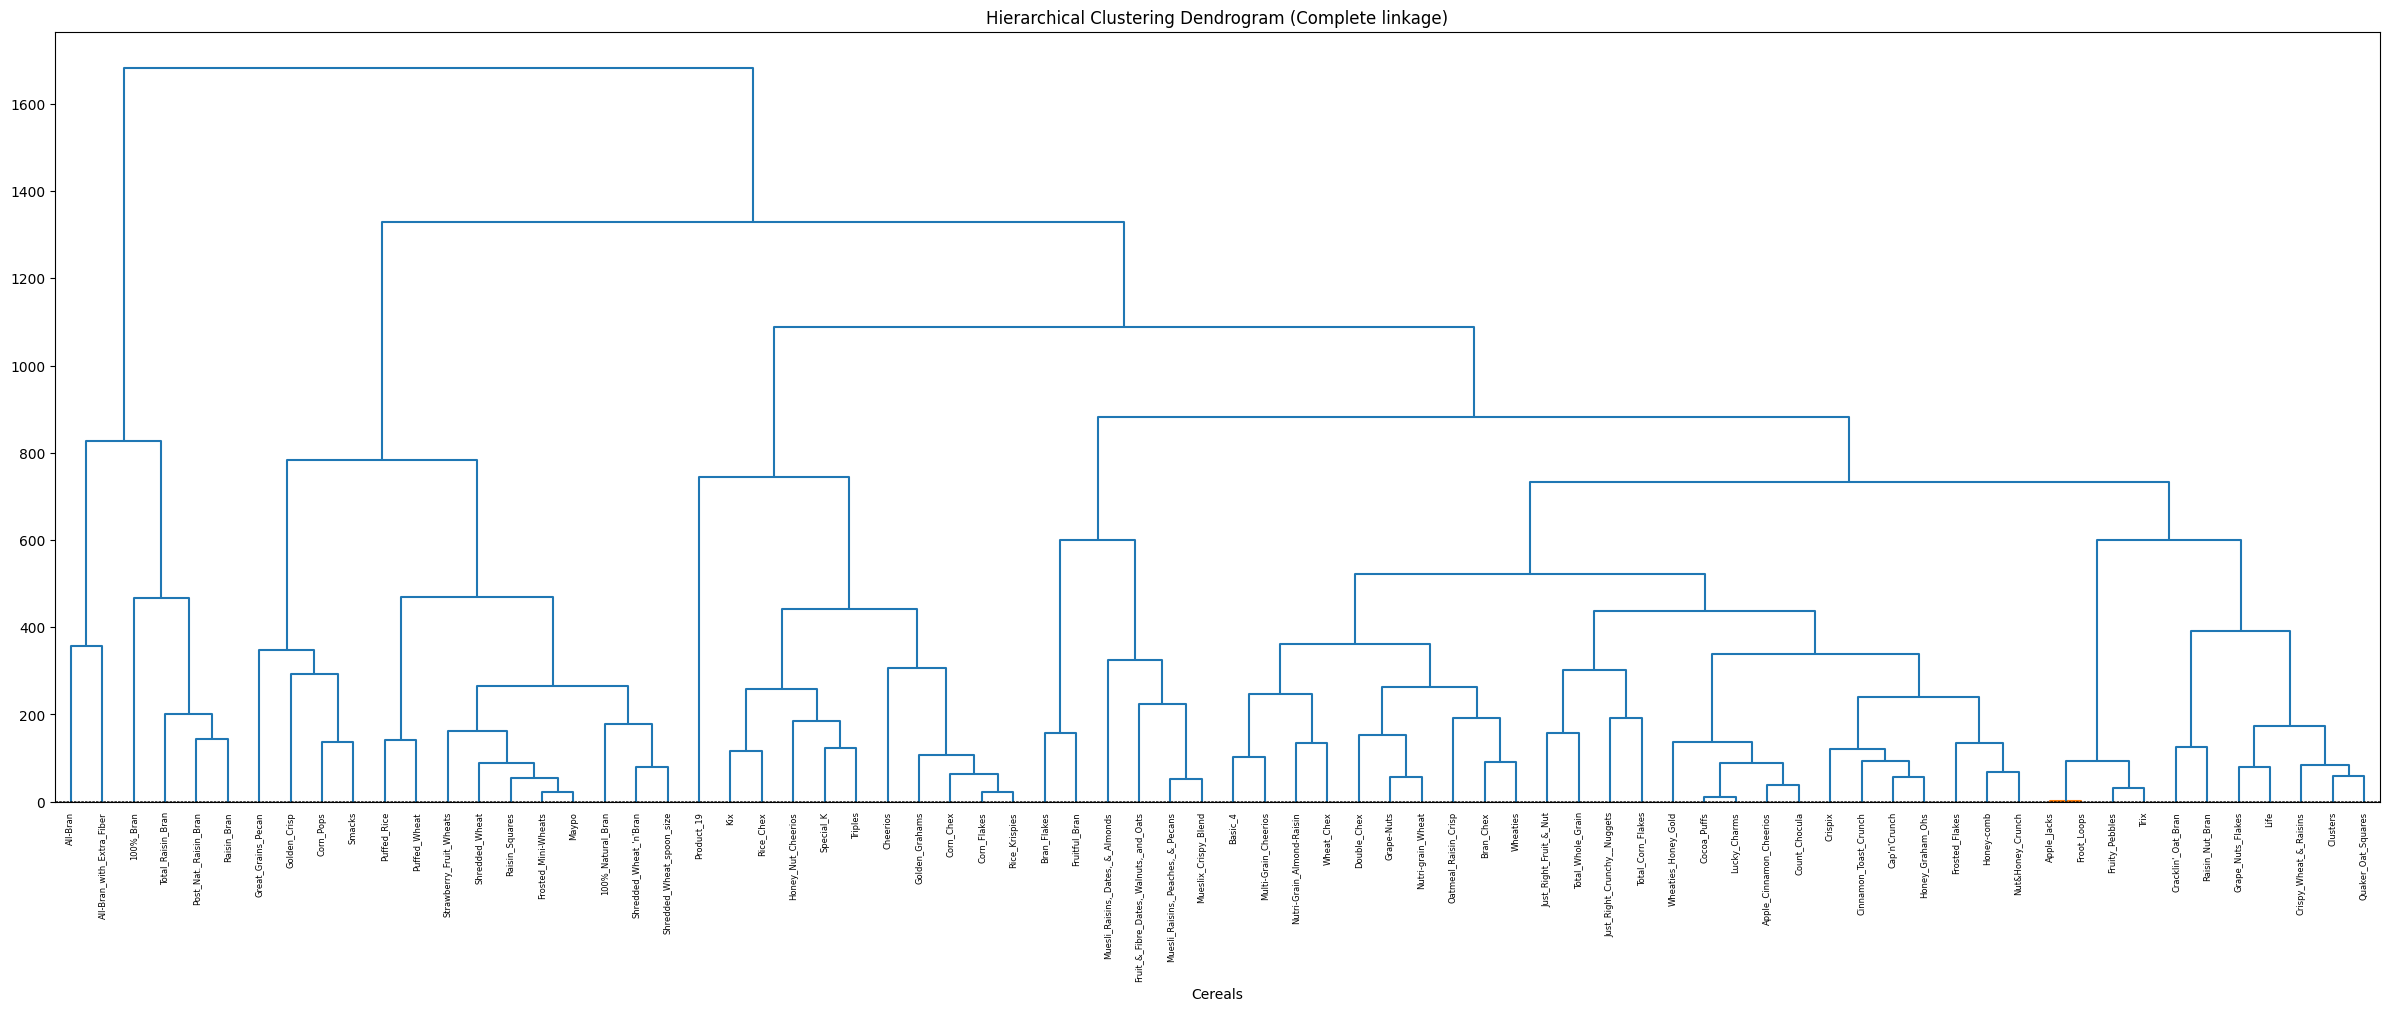

<ipython-input-42-a20ae8f195ce>:23: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  single = linkage(df_dist, method='single')


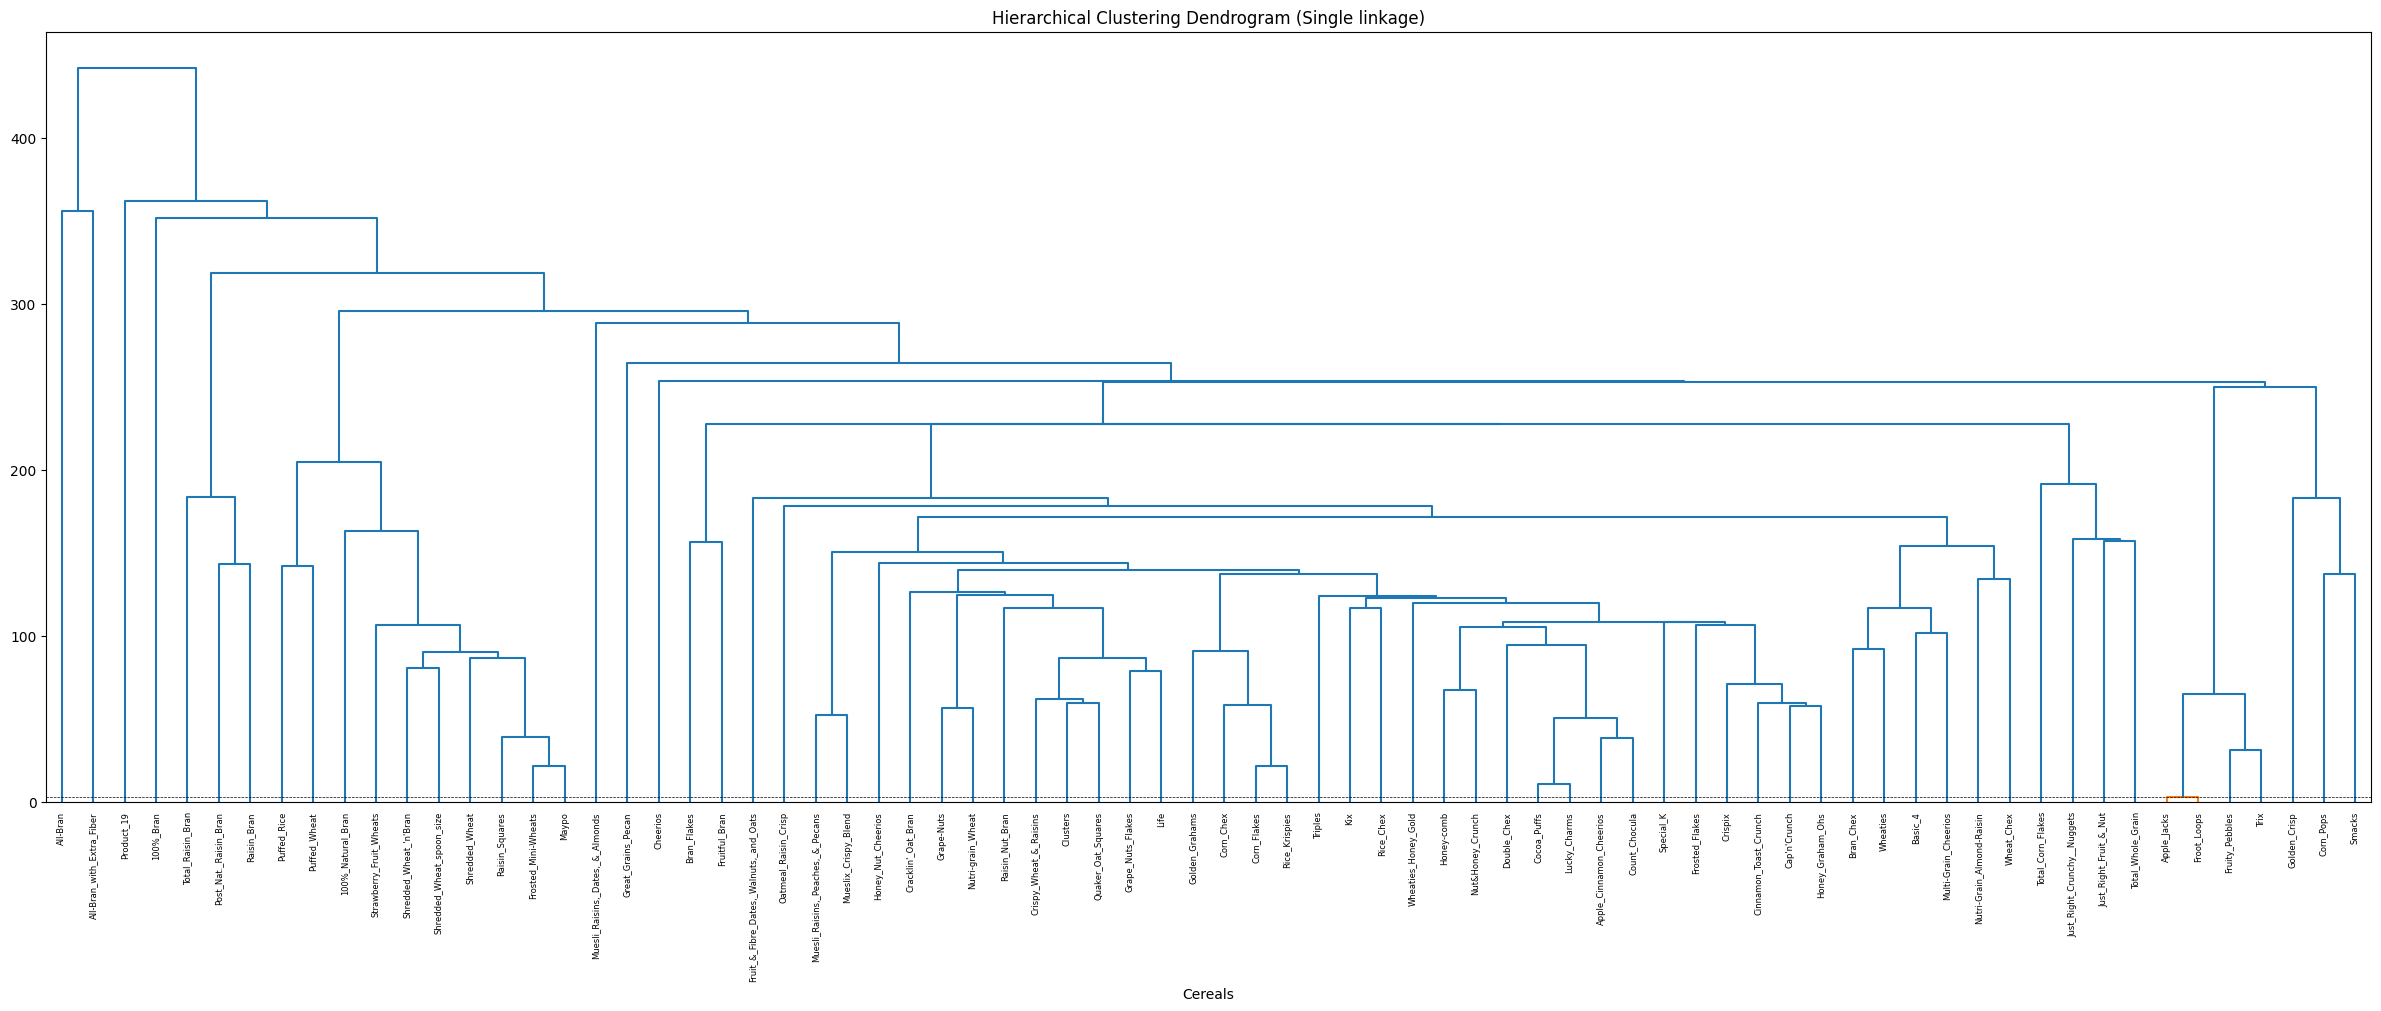

1 :  100%_Bran, All-Bran, All-Bran_with_Extra_Fiber, Bran_Flakes, Cracklin'_Oat_Bran, Fruit_&_Fibre_Dates,_Walnuts,_and_Oats, Fruitful_Bran, Muesli_Raisins,_Dates,_&_Almonds, Muesli_Raisins,_Peaches,_&_Pecans, Mueslix_Crispy_Blend, Post_Nat._Raisin_Bran, Raisin_Bran, Raisin_Nut_Bran, Total_Raisin_Bran
2 :  100%_Natural_Bran, Corn_Pops, Frosted_Mini-Wheats, Golden_Crisp, Great_Grains_Pecan, Maypo, Puffed_Rice, Puffed_Wheat, Raisin_Squares, Shredded_Wheat, Shredded_Wheat_'n'Bran, Shredded_Wheat_spoon_size, Smacks, Strawberry_Fruit_Wheats
3 :  Apple_Cinnamon_Cheerios, Apple_Jacks, Basic_4, Bran_Chex, Cap'n'Crunch, Cheerios, Cinnamon_Toast_Crunch, Clusters, Cocoa_Puffs, Corn_Chex, Corn_Flakes, Count_Chocula, Crispix, Crispy_Wheat_&_Raisins, Double_Chex, Froot_Loops, Frosted_Flakes, Fruity_Pebbles, Golden_Grahams, Grape_Nuts_Flakes, Grape-Nuts, Honey_Graham_Ohs, Honey_Nut_Cheerios, Honey-comb, Just_Right_Crunchy__Nuggets, Just_Right_Fruit_&_Nut, Kix, Life, Lucky_Charms, Multi-Grain_Cheerios

<ipython-input-42-a20ae8f195ce>:46: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  num_df["Cluster"] = fcluster(linkage(df_dist, 'complete'), 4, criterion='maxclust')
<ipython-input-42-a20ae8f195ce>:58: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  num_df["Cluster"] = fcluster(linkage(df_dist, 'single'), 4, criterion='maxclust')


In [ ]:
df = dmba.load_data('Cereals.csv')

# A. Apply hierarchical clustering to the data using Euclidean distance to the
# normalized measurements. Compare the dendrograms from single linkage and
# complete linkage, and look at cluster centroids. Comment on the structure of the
# clusters and on their stability. (Hint: To obtain cluster centroids for hierarchical
# clustering, compute the average values of each cluster members, using
# groupby() with the cluster centers followed by mean:
# dataframe.groupby(clusterlabel).mean().)
df = df.dropna(axis=0, how='any')
df.set_index('name', inplace=True)

df_dist = pairwise.pairwise_distances(df[['calories','protein','fat','sodium','fiber',
  'carbo','sugars','potass','vitamins','shelf','weight','cups','rating']], metric='euclidean')
complete = linkage(df_dist, method='complete')
fig = plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Cereals')
dendrogram(complete, labels=df.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

single = linkage(df_dist, method='single')
fig = plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Cereals')
dendrogram(single, labels=df.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

com_memb = fcluster(linkage(df[['calories','protein','fat','sodium','fiber','carbo','sugars',
  'potass','vitamins','shelf','weight','cups','rating']], 'complete'), 3, criterion='maxclust')
com_memb = pd.Series(com_memb, index=df.index)
for key, item in com_memb.groupby(com_memb):
    print(key, ': ', ', '.join(item.index))

sin_memb = fcluster(linkage(df[['calories','protein','fat','sodium','fiber','carbo','sugars',
  'potass','vitamins','shelf','weight','cups','rating']], 'single'), 3, criterion='maxclust')
sin_memb = pd.Series(sin_memb, index=df.index)
for key, item in sin_memb.groupby(sin_memb):
    print(key, ': ', ', '.join(item.index))

num_df = df
num_df = df.drop(['mfr','type'], axis=1)

num_df["Cluster"] = fcluster(linkage(df_dist, 'complete'), 4, criterion='maxclust')
print("\nCOMPLETE CENTROID:\n")
print("Cluster 1:")
num_clust_one = num_df.groupby(["Cluster"]).get_group(1).mean().to_frame().T
print(num_clust_one)
print('\nCluster 2:')
num_clust_two = num_df.groupby(["Cluster"]).get_group(2).mean().to_frame().T
print(num_clust_two)
print('\nCluster 3:')
num_clust_three = num_df.groupby(["Cluster"]).get_group(3).mean().to_frame().T
print(num_clust_three)

num_df["Cluster"] = fcluster(linkage(df_dist, 'single'), 4, criterion='maxclust')
print("\nSINGLE CENTROID:\n")
print("Cluster 1:")
num_clust_one = num_df.groupby(["Cluster"]).get_group(1).mean().to_frame().T
print(num_clust_one)
print('\nCluster 2:')
num_clust_two = num_df.groupby(["Cluster"]).get_group(2).mean().to_frame().T
print(num_clust_two)
print('\nCluster 3:')
num_clust_three = num_df.groupby(["Cluster"]).get_group(3).mean().to_frame().T
print(num_clust_three)
# The complete clustering method looks more clean and sorted than the single method

# B. Which method leads to the most insightful or meaningful clusters?
# The complete approach looks as though it leads to more optimal clusters

# C. Choose one of the methods. How many clusters would you use? What distance
# is used for this cutoff? (Look at the dendrogram.)
# I would use 3 clusters for the complete method.

# D. The elementary public schools would like to choose a set of cereals to include in
# their daily cafeterias. Every day a different cereal is offered, but all cereals should
# support a healthy diet. For this goal, you are requested to find a cluster of
# “healthy cereals.” Should the data be normalized? If not, how should they be
# used in the cluster analysis?
# The data may be normalized to determine a more "relative" cluster for healthy,
# but for a non-relative approach to the other cereals in the store, normalization should be avoided.

**Question 4: Marketing to Frequent Fliers.**

The file EastWestAirlinesCluster.csv contains information on 3999 passengers who belong to an airline’s frequent flier program. For each passenger, the data include information on their mileage history and on different ways they accrued or spent miles in the last year. The goal is to try to identify clusters of passengers that have similar characteristics for the purpose of targeting different segments for different types of mileage offers.

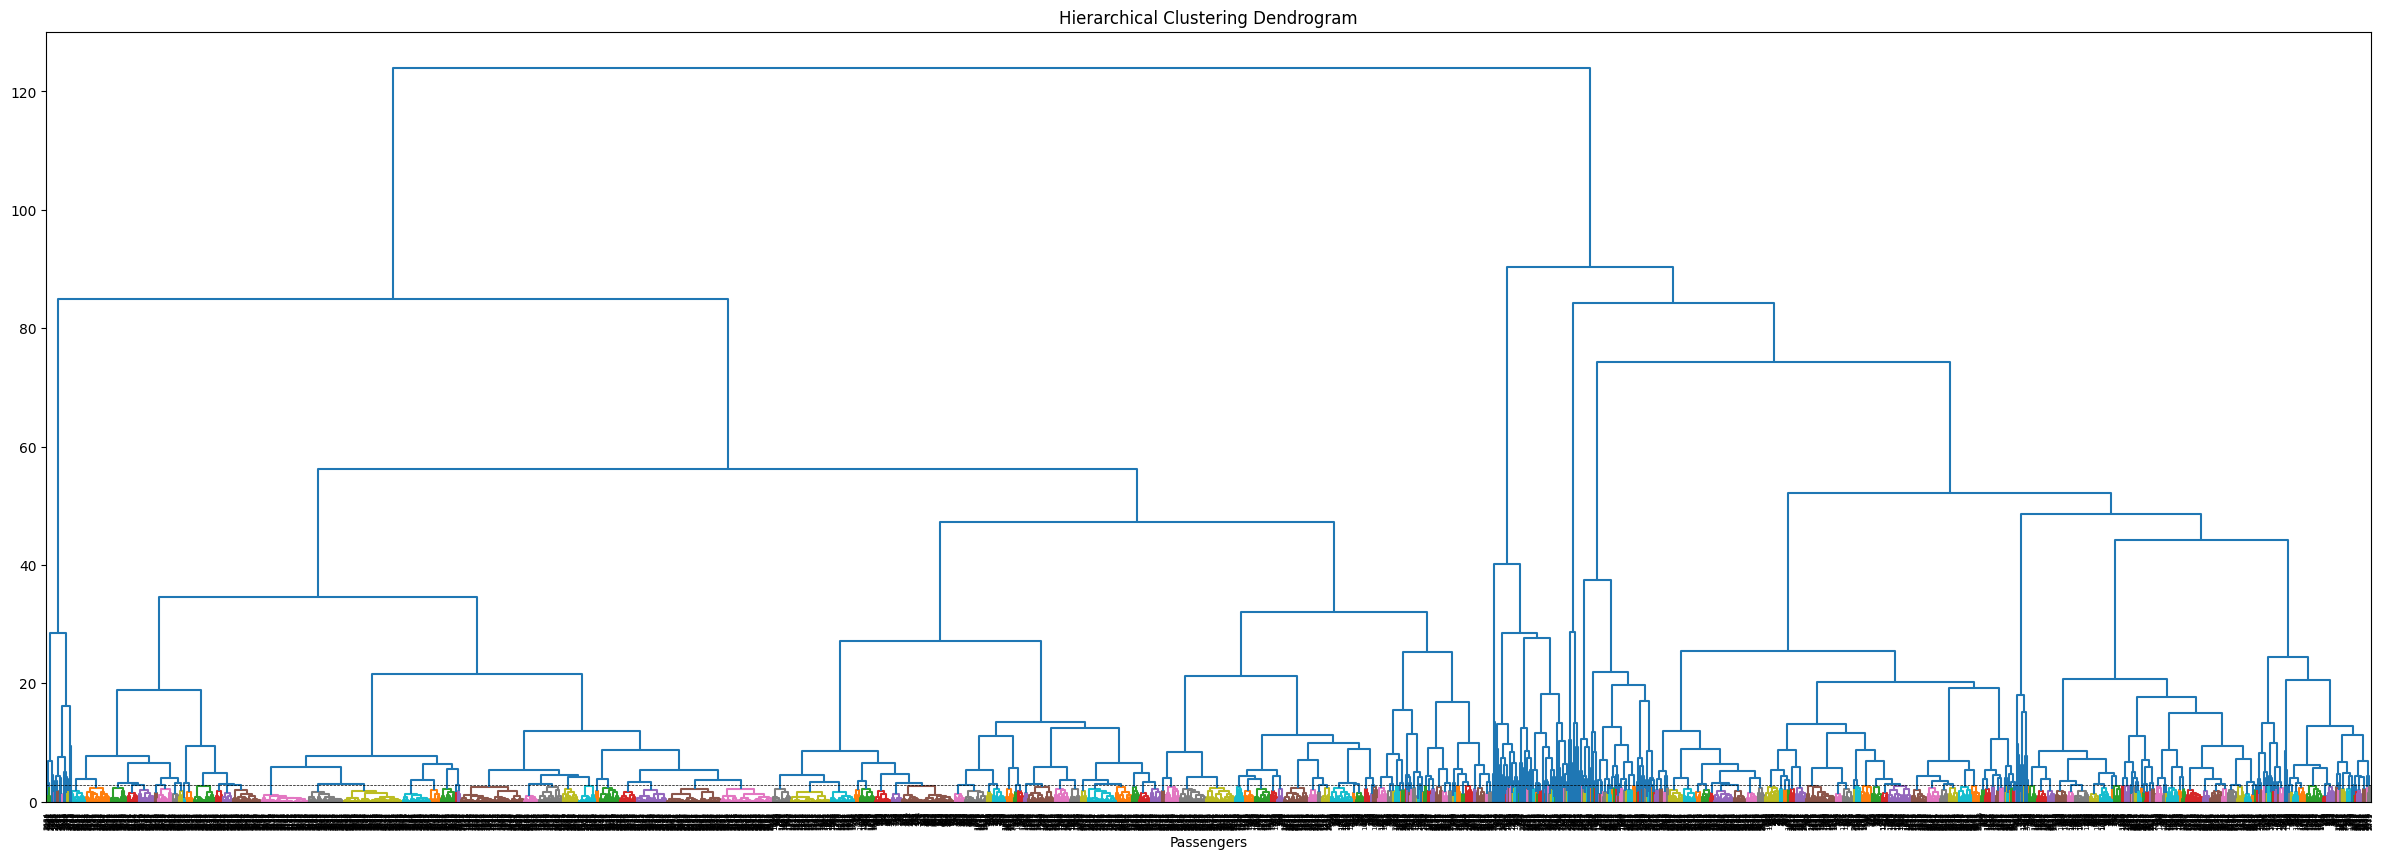

In [ ]:
df= dmba.load_data('EastWestAirlinesCluster.csv')

# A. Apply hierarchical clustering with Euclidean distance and Ward’s method. Make
# sure to normalize the data first. How many clusters appear?
df.set_index('ID#', inplace=True)
df_norm = df
df_norm = (df - df.mean())/df.std()

df_clust = linkage(df_norm, method='ward', metric='euclidean')
fig = plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Passengers')
dendrogram(df_clust, labels=df_norm.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()
# A large amount of clusters appear, optimally about 6 should be focused on

# B. What would happen if the data were not normalized?
# If the data were not normalized, some of the values would massively skew the clustering

In [ ]:
# C. Compare the cluster centroid to characterize the different clusters, and try to give
# each cluster a label.
df["Cluster"] = fcluster(df_clust, 6, criterion='maxclust')
print("\nNORMALIZED CENTROIDS:\n")
print("Cluster 1:")
print(df.groupby(["Cluster"]).get_group(1).mean().to_frame().T)
print('\nCluster 2:')
print(df.groupby(["Cluster"]).get_group(2).mean().to_frame().T)
print('\nCluster 3:')
print(df.groupby(["Cluster"]).get_group(3).mean().to_frame().T)
print('\nCluster 4:')
print(df.groupby(["Cluster"]).get_group(4).mean().to_frame().T)
print('\nCluster 5:')
print(df.groupby(["Cluster"]).get_group(5).mean().to_frame().T)
print('\nCluster 6:')
print(df.groupby(["Cluster"]).get_group(6).mean().to_frame().T)
# Cluster 1: Recent enrollment, high bonus miles
# Cluster 2: Recent enrollment, low bonus miles
# Cluster 3: Medium enrollment, low bonus miles
# Cluster 4: Medium enrollment, high bonus miles
# Cluster 5: Long enrollment, low bonus miles
# Cluster 6: Long enrollment, high bonus miles

# D. To check the stability of the clusters, remove a random 5% of the data (by taking
# a random sample of 95% of the records), and repeat the analysis. Does the
# same picture emerge?
np.random.seed(10)
remove_num = math.floor(len(df) * 0.05)
df_dropped = df.drop(['Cluster'],axis=1)
df_dropped = df_dropped.drop(np.random.choice(df_dropped.index, remove_num, replace=False))

dropped_norm = (df_dropped - df_dropped.mean())/df_dropped.std()
new_clust = linkage(dropped_norm, method='ward', metric='euclidean')

df_dropped["Cluster"] = fcluster(new_clust, 6, criterion='maxclust')
print("\n\nSAMPLE CENTROIDS:\n")
print("Cluster 1:")
print(df_dropped.groupby(["Cluster"]).get_group(1).mean().to_frame().T)
print('\nCluster 2:')
print(df_dropped.groupby(["Cluster"]).get_group(2).mean().to_frame().T)
print('\nCluster 3:')
print(df_dropped.groupby(["Cluster"]).get_group(3).mean().to_frame().T)
print('\nCluster 4:')
print(df_dropped.groupby(["Cluster"]).get_group(4).mean().to_frame().T)
print('\nCluster 5:')
print(df_dropped.groupby(["Cluster"]).get_group(5).mean().to_frame().T)
print('\nCluster 6:')
print(df_dropped.groupby(["Cluster"]).get_group(6).mean().to_frame().T)
# The resulting means are different enough from the last batch that the labels no longer fit the clusters

# E. Use k-means clustering with the number of clusters that you found above. Does
# the same picture emerge?
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_norm)
df['Cluster'] = pd.Series(kmeans.labels_, index=df_norm.index)
print("\n\nKMEANS CENTROIDS:\n")
print("Cluster 1:")
print(df.groupby(["Cluster"]).get_group(0).mean().to_frame().T)
print('\nCluster 2:')
print(df.groupby(["Cluster"]).get_group(1).mean().to_frame().T)
print('\nCluster 3:')
print(df.groupby(["Cluster"]).get_group(2).mean().to_frame().T)
print('\nCluster 4:')
print(df.groupby(["Cluster"]).get_group(3).mean().to_frame().T)
print('\nCluster 5:')
print(df.groupby(["Cluster"]).get_group(4).mean().to_frame().T)
print('\nCluster 6:')
print(df.groupby(["Cluster"]).get_group(5).mean().to_frame().T)
# Yet again the labels from the initial clustering does not match

# F. Which clusters would you target for offers, and what types of offers would you
# target to customers in that cluster?
# I would target longer enrolled members with the lower qualified miles for more
# qualified miles to raise committed member morale


NORMALIZED CENTROIDS:

Cluster 1:
        Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll    Award?  Cluster
0  68876.581395   23.255814   1.139535   2.348837        1.0  14689.837209    17.534884         582.627907         2.209302        3968.930233  0.395349      1.0

Cluster 2:
        Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll    Award?  Cluster
0  46329.336877    9.028618   1.244072        1.0        1.0  4868.112428     6.907604         214.812756         0.673753        3769.337694  0.184383      2.0

Cluster 3:
         Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll    Award?  Cluster
0  134880.892308  393.323077   2.430769        1.0        1.0  36582.169231    29.338462        5915.523077        16.638462        

**Question 5: Discovering Frequent Flyer Groups with DBSCAN (Density-Based Spatial Clustering of Applications with Noise).**

The dataset EastWestAirlinesCluster.csv contains information on 3999 passengers who belong to an airline’s frequent flier program. For each passenger, the data include various details on their mileage history and different ways they accrued or spent miles in the last year.

The goal is to use DBSCAN to identify different groups of passengers based on their flight and mileage behaviors. Since DBSCAN doesn't require specifying the number of
clusters beforehand, it's well-suited for identifying irregularly shaped clusters and noise points, which may represent outliers or passengers with unusual patterns.

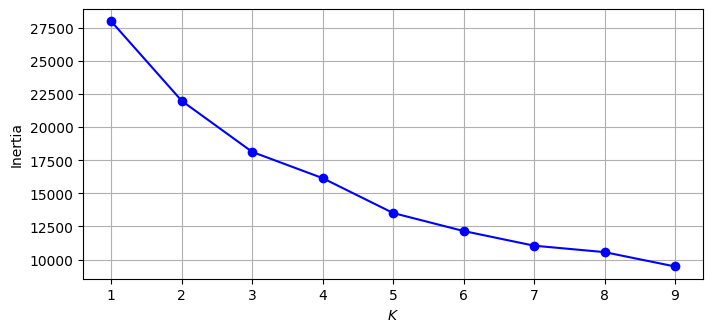

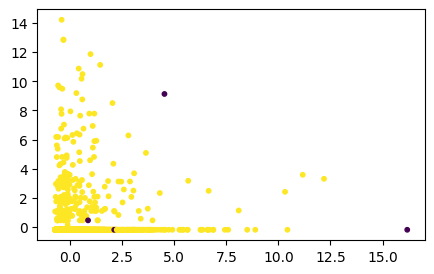

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

df= dmba.load_data('EastWestAirlinesCluster.csv')

# A. Prepare the Data
# • Select appropriate numerical features for clustering.
# • Normalize the data to ensure that all variables contribute equally to the distance
# metric.
df.set_index('ID#', inplace=True)
df = df.drop(['cc1_miles','cc2_miles','cc3_miles','Award?'], axis=1)
df_norm = df
df_norm = (df - df.mean())/df.std()

df_norm.head(10)

# B. Finding the Optimal Parameters for DBSCAN
# • Use the NearestNeighbors approach to determine the optimal epsilon (eps)
# parameter by examining the elbow plot.
# • Set min_samples to 5 (default for DBSCAN) and apply DBSCAN to the
# normalized data.
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_norm)
  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$K$")
plt.ylabel("Inertia")
plt.grid()
plt.show()
# Elbow plot seems to show 5 as K

dbscan = DBSCAN(eps=5, min_samples=5)
points = df_norm.to_numpy()
pred = dbscan.fit(points)
plt.scatter(points[:,0], points[:,1], c=dbscan.labels_, s=10)
plt.show()

# C. Analyzing the Results
# • How many clusters did DBSCAN identify? How many points were classified as
# noise (outliers)?
# • Examine the cluster centroids to understand the characteristics of each group.
# • How does the presence of noise points help in identifying outliers? Discuss the
# characteristics of these outliers.
# DBSCAN identified one cluster. 4 points were identified as outliers.
# The noise points are mostly far away from the centroid, as they do not mostly fit the pattern
# Characteristics of these outliers are that they are far from the centroid and away from other points

# D. Cluster Insights and Recommendations
# • Based on the identified clusters, which group of frequent flyers would you target
# for special offers, and why?
# • Provide one marketing strategy per cluster, tailored to the flight behavior and
# spending characteristics of that group.
# There was only one cluster, therefore there is no particular cluster to target.

**Question 6: Segmenting Consumers of Bath Soap.**

**Business Situation**

CRISA is an Asian market research agency that specializes in tracking consumer purchase behavior in consumer goods (both durable and nondurable). In one major research project, CRISA tracks numerous consumer product categories (e.g.,
“detergents”), and, within each category, perhaps dozens of brands. To track purchase behavior, CRISA constituted household panels in over 100 cities and towns in India,
covering most of the Indian urban market. The households were carefully selected using stratified sampling to ensure a representative sample; a subset of 600 records is
analyzed here. The strata were defined on the basis of socioeconomic status and the market (a collection of cities).

CRISA has both transaction data (each row is a transaction) and household data (each row is a household), and for the household data it maintains the following information:

Demographics of the households (updated annually)

Possession of durable goods (car, washing machine, etc., updated annually; an “affluence index” is computed from this information)

Purchase data of product categories and brands (updated monthly)

CRISA has two categories of clients: (1) advertising agencies that subscribe to the database services, obtain updated data every month, and use the data to advise their
clients on advertising and promotion strategies; (2) consumer goods manufacturers, which monitor their market share using the CRISA database.

**Key Problems**

CRISA has traditionally segmented markets on the basis of purchaser demographics. They would now like to segment the market based on two key sets of variables more
directly related to the purchase process and to brand loyalty:

Purchase behavior (volume, frequency, susceptibility to discounts, and brand loyalty)

Basis of purchase (price, selling proposition)

Doing so would allow CRISA to gain information about what demographic attributes are associated with different purchase behaviors and degrees of brand loyalty, and thus
deploy promotion budgets more effectively. More effective market segmentation would enable CRISA’s clients (in this case, a firm called IMRB) to design more cost-effective
promotions targeted at appropriate segments. Thus, multiple promotions could be launched, each targeted at different market segments at different times of the year. This
would result in a more cost-effective allocation of the promotion budget to different market segments. It would also enable IMRB to design more effective customer reward
systems and thereby increase brand loyalty.

**Data**

The data in Table below profile each household, each row containing the data for one
household.

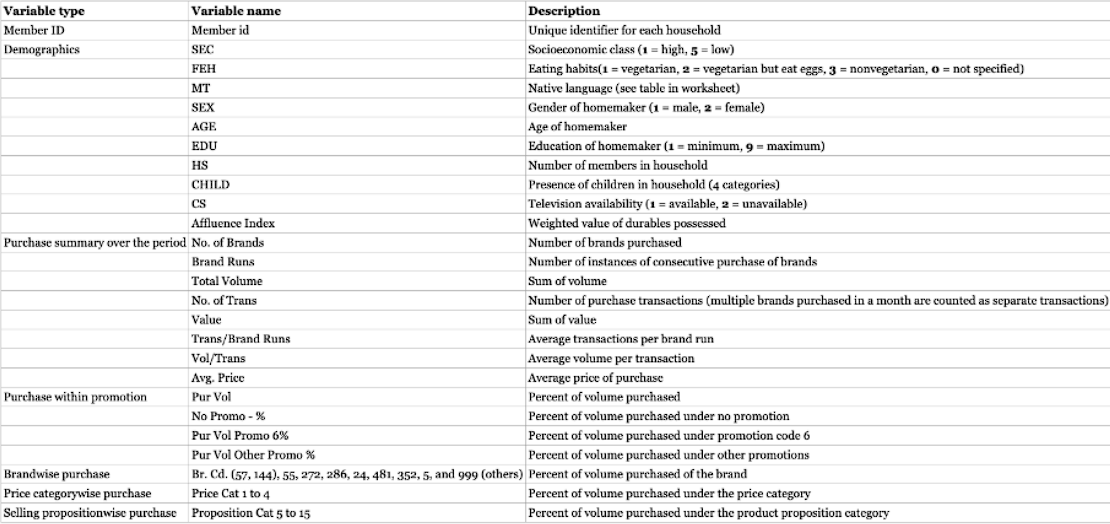


**Measuring Brand Loyalty**

Several variables in this case measure aspects of brand loyalty. The number of different brands purchased by the customer is one measure of loyalty. However, a consumer
who purchases one or two brands in quick succession, then settles on a third for a long streak, is different from a consumer who constantly switches back and forth among
three brands. Therefore, how often customers switch from one brand to another is another measure of loyalty. Yet a third perspective on the same issue is the proportion
of purchases that go to different brands—a consumer who spends 90% of his or her purchase money on one brand is more loyal than a consumer who spends more equally
among several brands.

All three of these components can be measured with the data in the purchase summary worksheet.

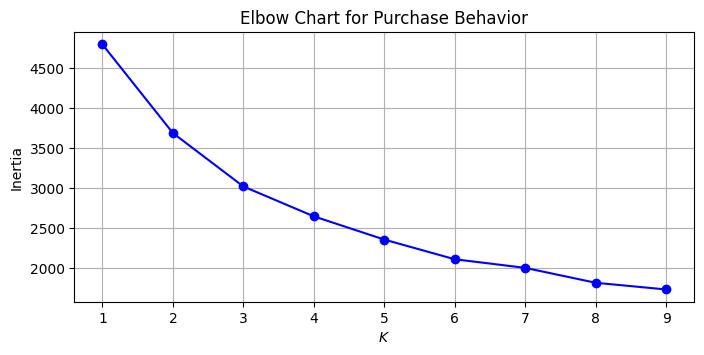

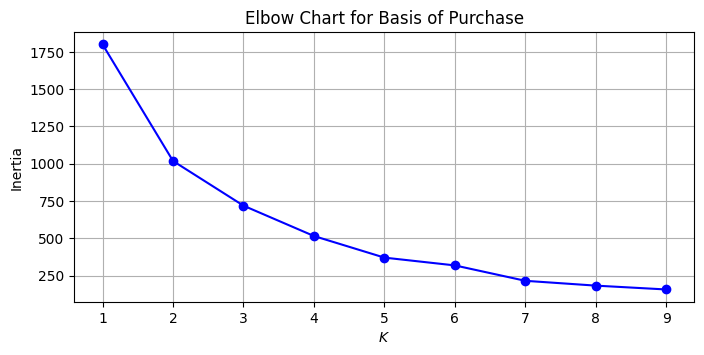

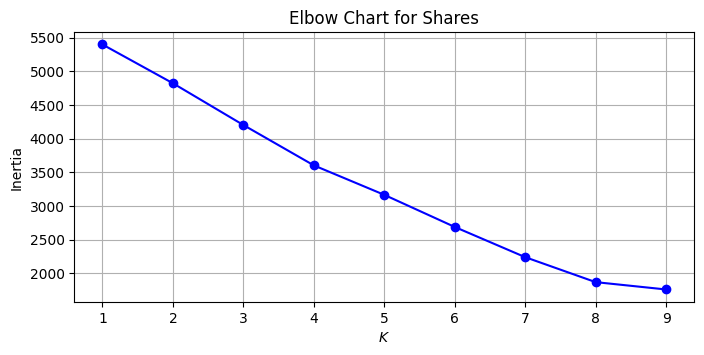

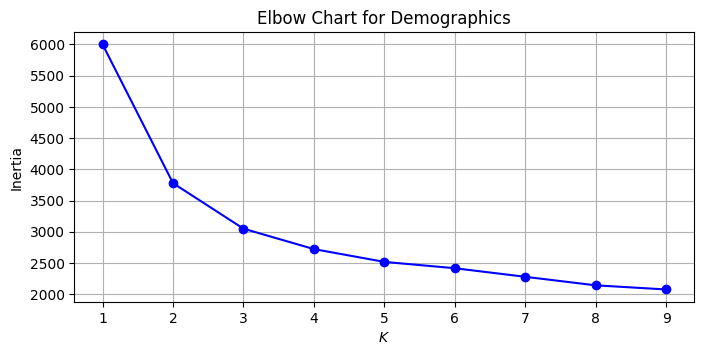



SAMPLE CENTROIDS:

Cluster 1:
    Member id      SEC       FEH      MT       SEX       AGE    EDU        HS     CHILD        CS  ...  PropCat 7  PropCat 8  PropCat 9  PropCat 10  PropCat 11  PropCat 12  \
0  1132631.25  1.59375  2.010417  8.8125  1.979167  3.302083  5.625  4.760417  2.885417  1.041667  ...   0.129322   0.108905   0.026092    0.038172    0.037841    0.008607   

   PropCat 13  PropCat 14  PropCat 15  Cluster  
0    0.032953    0.018553    0.027863      1.0  

[1 rows x 47 columns]
Cluster 2:
      Member id       SEC  FEH   MT  SEX       AGE  EDU   HS  CHILD   CS  ...  PropCat 7  PropCat 8  PropCat 9  PropCat 10  PropCat 11  PropCat 12  PropCat 13  PropCat 14  \
0  1.111970e+06  2.205882  0.0  0.0  0.0  2.705882  0.0  0.0    5.0  0.0  ...   0.079348   0.096391   0.024628    0.032054    0.010617    0.012678    0.061345    0.195813   

   PropCat 15  Cluster  
0       0.005      2.0  

[1 rows x 47 columns]
Cluster 3:
      Member id       SEC       FEH       MT       S

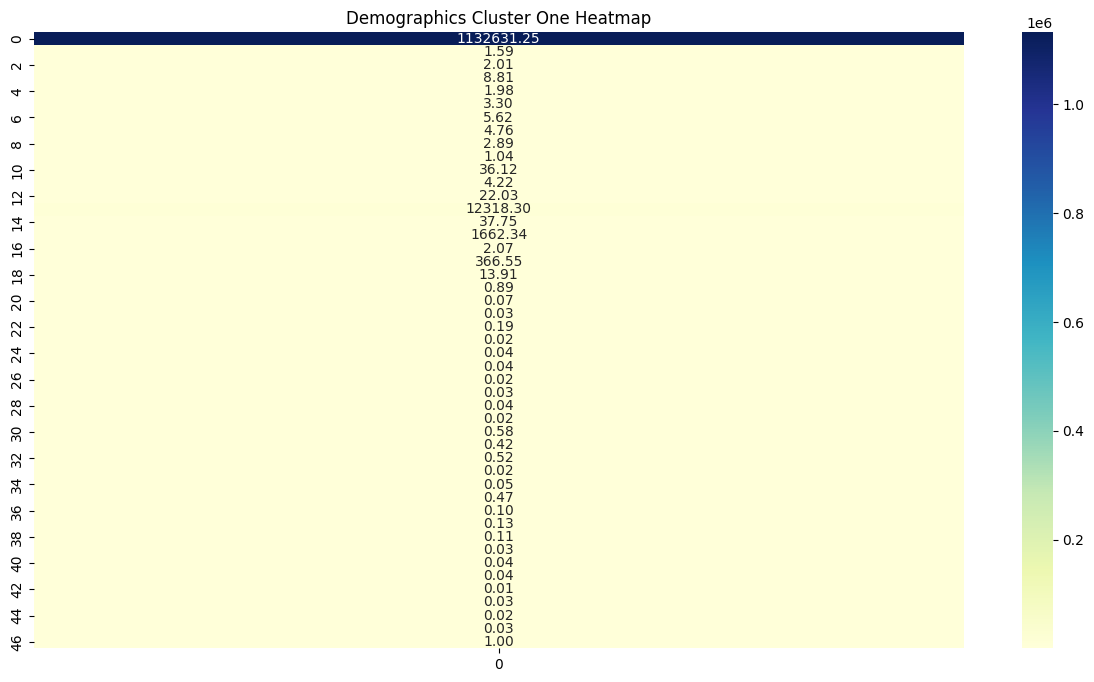

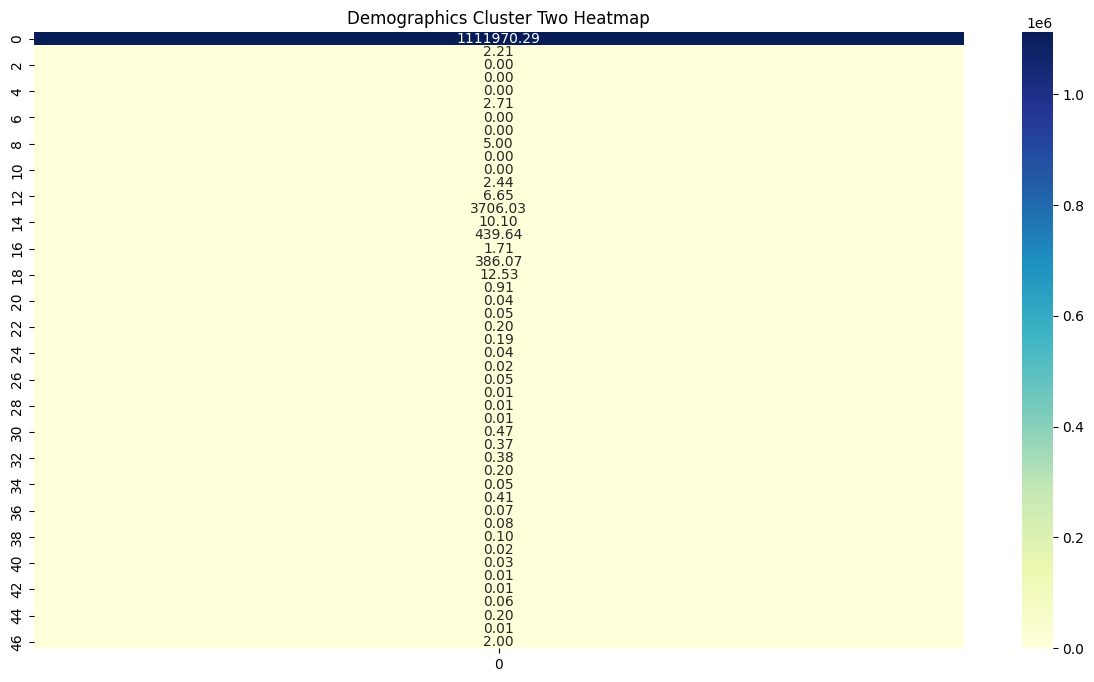

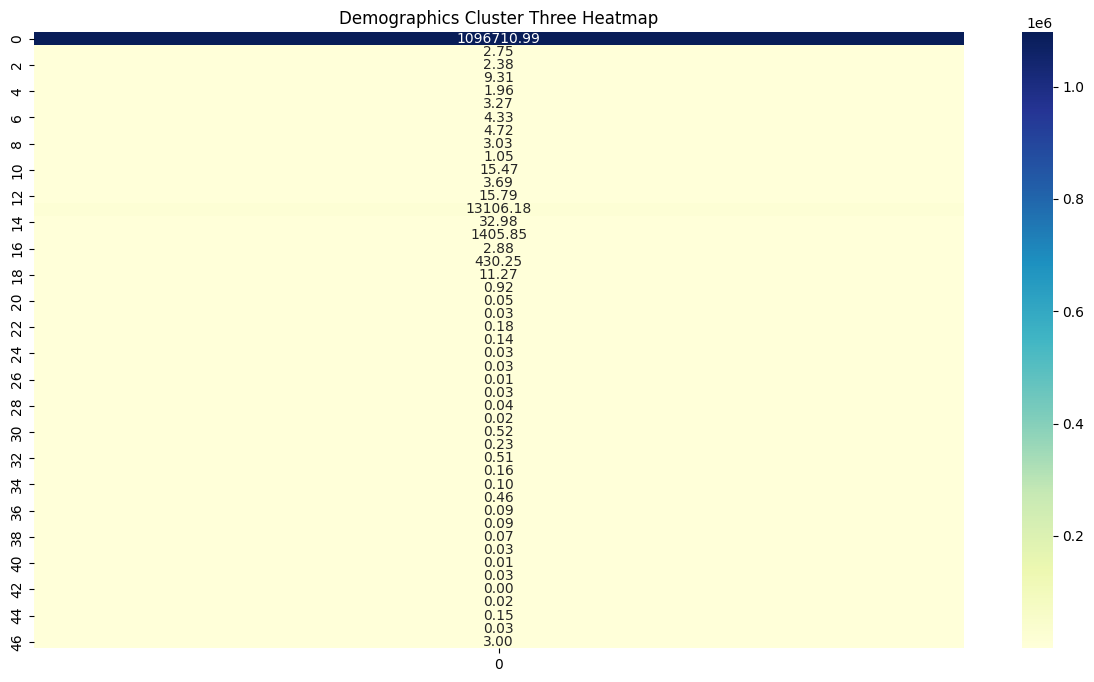

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

df = dmba.load_data('BathSoapHousehold.csv')

# 1. Use k-means clustering to identify clusters of households based on:
# A. The variables that describe purchase behavior (including brand loyalty)
# B. The variables that describe the basis for purchase
# C. The variables that describe both purchase behavior and basis of purchase
# Note 1: How should k be chosen? Think about how the clusters would be used. It is
# likely that the marketing efforts would support two to five different promotional
# approaches.
# Note 2: How should the percentages of total purchases comprised by various brands be
# treated? Isn’t a customer who buys all brand A just as loyal as a customer who buys all
# brand B? What will be the effect on any distance measure of using the brand share
# variables as is? Consider using a single derived variable.
behavior = ['No. of Brands','Brand Runs','Total Volume','No. of  Trans','Value','Trans / Brand Runs',
            'Vol/Tran','Avg. Price ']
basis = ['Pur Vol No Promo - %','Pur Vol Promo 6 %','Pur Vol Other Promo %']
shares = ['Br. Cd. 57, 144','Br. Cd. 55','Br. Cd. 272','Br. Cd. 286','Br. Cd. 24',
          'Br. Cd. 481','Br. Cd. 352','Br. Cd. 5','Others 999']
demo = ['SEC','FEH','MT','SEX','AGE','EDU','HS','CHILD','CS','Affluence Index']

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(df[behavior]))
  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.title("Elbow Chart for Purchase Behavior")
plt.xlabel("$K$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(df[basis]))
  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.title("Elbow Chart for Basis of Purchase")
plt.xlabel("$K$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(df[shares]))
  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.title("Elbow Chart for Shares")
plt.xlabel("$K$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(df[demo]))
  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.title("Elbow Chart for Demographics")
plt.xlabel("$K$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

# Will not have enough time to finish homework assignment today, turning in incomplete

# 2. Select what you think is the best segmentation and comment on the
# characteristics (demographic, brand loyalty, and basis for purchase) of these
# clusters. (This information would be used to guide the development of advertising
# and promotional campaigns.)

new_clust = linkage(df[demo], method='ward', metric='euclidean')
df["Cluster"] = fcluster(new_clust, 3, criterion='maxclust')
print("\n\nSAMPLE CENTROIDS:\n")
print("Cluster 1:")
clust_one = df.groupby("Cluster"]).get_group(1).mean()
print(clust_one.to_frame().T)
print("Cluster 2:")
clust_two = df.groupby(["Cluster"]).get_group(2).mean()
print(clust_two.to_frame().T)
print("Cluster 3:")
clust_three = df.groupby(["Cluster"]).get_group(3).mean()
print(clust_three.to_frame().T)

plt.figure(figsize=(15, 8))
sns.heatmap(np.asarray(clust_one).reshape(47,1), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Demographics Cluster One Heatmap')
plt.show()

plt.figure(figsize=(15, 8))
sns.heatmap(np.asarray(clust_two).reshape(47,1), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Demographics Cluster Two Heatmap')
plt.show()

plt.figure(figsize=(15, 8))
sns.heatmap(np.asarray(clust_three).reshape(47,1), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Demographics Cluster Three Heatmap')
plt.show()

# 3. Develop a model that classifies the data into these segments. Since this
# information would most likely be used in targeting direct-mail promotions, it would
# be useful to select a market segment that would be defined as a success in the
# classification model.